In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
print("PyMC3 version is {}".format(pm.__version__))
print("numpy version is {}".format(np.__version__))
print("pandas version is {}".format(pd.__version__))

PyMC3 version is 3.8
numpy version is 1.18.1
pandas version is 1.0.1


# Bayesian approach to Net Promoter Score analysis


##  Introduction
This short analysis is a PyMC3 port of this excellent blog post on approaching NPS analysis using a Bayesian
framework (https://blog.ivanukhov.com/2019/08/19/net-promoter.html). Credits for the original idea go the blog post author. Here I try to unpack the blog post, try out an additional idea while porting the Stan code to PyMC3. 

## What is NPS?

Net Promoter Score or NPS is a simple metric that is often used to guage the client loyalty of a company. 
The Net Promoter Score is calculated based on responses to a single question: *How likely is it that you would recommend our company/product/service to a friend or colleague?* The scoring for this answer is most often based on a 0 to 10 scale.

A client who responds with a score of 9 to 10 is a Promoter (thought to exhibit more value-creating behaviors). 
A client who responds with a score of 0 to 6 is a  Detractor (thought to exhibit less value-creating behaviors and potentially churning). 
A client who responds with a score of 7 to 8 is a  Neutral (somewhere between Promoter and Detractor). 


The Net Promoter Score is calculated by subtracting the percentage of customers who are Detractors from the percentage of customers who are Promoters. For purposes of calculating a Net Promoter Score, Neutrals count toward the total number of respondents, thus decreasing the percentage of detractors and promoters and pushing the net score toward 0. 

Mathematically, let $p$ denote the number of promoters, $n$ denote the number of neutrals and $d$ denote the number of detractors. Then the NPS is calculated as 

$$ \text{nps} = \frac{p - d}{p + n + d}.$$

Note that NPS scores lie between -1 and 1. 

More details about NPS can be found [here](https://www.surveymonkey.com/mp/net-promoter-score/) and [here](https://en.wikipedia.org/wiki/Net_Promoter)



## Properties

1. The biggest problem with a single number that NPS gives is that since it is the difference of two ratios, it is scale invariant. For example $p=10$, $d=5$, $n=0$ gives an NPS score of 0.33 or 33%; the same as for when 
$p=353$, $d=20$, $n=627$. Here the general set of number of detractors, promoters and neutrals is very different but the single value NPS score is the same. Intuitively we expect that these numbers should lead to different NPS scores. 

2. The second set of numbers above should provide us a more "confident" NPS score because the volume of the respondents is higher.

The first issue is a general criticism of the metric defintion which we won't address here. Instead we aim to tackle the second issue by providing uncertainty estimations for NPS calculations. The basic intuition here is that the smaller volume of respondents we have, the less confident we are about the NPS score. After all the number of respondents is usually a subset of the general population and any conclusion we make about the general population
based on analysis on a subset should come with some uncertainty quantifications :)



## Solution

The linked blog post proposes a Hierachical Bayesian model. The *proportion* of promoters, passives and detractors is modeled by a 3-arm multinomial distribution $\hat{\theta} = (\theta_{p}, \theta_{n}, \theta_{d})$ and it is this random variable for which the posterior distribution is to be calculated. 

Note that $\hat{\theta} \in [0, 1]^3$. Parameter $\hat{\theta}$ can also be thought of as a vector of probabilities of observing one of the three types of customers in segment that is, detractors, neutrals, and promoters.

If the true value of $\theta$ was known i.e if we knew the value of this parameter for the entire population then the NPS score would simply be calculated as $\text{nps} = \theta_{p} - \theta_{d}$. Since we have survey information on only a subset of the population, we can only infer this true value. That's why we treat each proportion as a random variable, look at the data, compute the posteriors of these proportions and hence get a *disribution* for the posterior NPS score.

Note that each respondent can be exactly one of promoter, detractor or neutral. A natural model for the observed data is thus a multinomial distribution with $p + n + d$ trials and probabilities $\hat{\theta} = (\theta_{p}, \theta_{n}, \theta_{d})$.

The above gives a data distribution. In order to complete the modeling part, we need to decide on a prior probability distribution for $\hat{\theta}$ which is a simplex of probabilities. We will try out two models. 



## Models

1. 

**Dirichlet-Multinomial Conjugate**

Since Dirichlet is the conjugate prior for Multinomial we propose a simple model

$
\begin{align*}
 \begin{aligned}
    &y|\hat{\theta} \sim \text{Multinomial}\;(p + n + d, (\theta_{p}, \theta_{n}, \theta_{d})) \;\;\text{       (likelihood)} \\
    &\hat{\theta} \sim \text{Dirichlet}\;[1, 1, 1]\;\;\;\text{(Uniform prior)}
 \end{aligned}
 \end{align*}
$
2. 
**A hierarchical model**, as proposed in the blog post, with the following structure. Details for the choice of hyper-priors are provided in the blog post. 

$
\begin{align*}
 \begin{aligned}
    &y|\hat{\theta} \sim \text{Multinomial}\;(p + n + d, (\theta_{p}, \theta_{n}, \theta_{d})) \text{       (likelihood)} \\
    &\hat{\theta}|\mu, \sigma \sim \text{Dirichlet}\;\left(\frac{\mu}{\sigma^2}\right)\;\;\;\text{(prior)} \\
    &\mu \sim \text{Uniform}\;[0, 1]^3\;\;\;\text{(hyperprior)} \\
    &\sigma \sim \text{Half-Cauchy}\;(loc=0, scale=1)\;\;\;\text{(hyperprior)}
\end{aligned}
\end{align*}
$

The half-Cauchy is usually used for a scale parameter and is quite heavy tailed may be regarded as fairly weakly informative in some situations.

In both the cases we can use MCMC methods to sample from the posterior distributions for $\hat{\theta}$. 

### Model 1: Smaller sample size

In [2]:

number_of_arms = 3 # (promoter, neutral, detractor)

responses_counts = [10, 0, 5]  # (10 promoters, 0 neutrals, 5 detractors)
#responses_counts = [353, 627, 20] # (353 promoters, 627 neutrals and 20 detractors)

#Note that in both the cases above the point NPS score is the same

point_nps_score = (responses_counts[0] - responses_counts[2])/sum(responses_counts)

In [3]:
with pm.Model() as conjugate_model:
    
    theta = pm.Dirichlet('theta', a=np.ones(number_of_arms))
    
    observed = pm.Multinomial('observed', 
                              n=sum(responses_counts),
                              p=theta, 
                              observed=responses_counts)
    
    nps = pm.Deterministic("nps", theta[0] - theta[2]) #proportion of promoters - proportion of detractors

In [4]:
# Inference button
with conjugate_model:
    conjugate_trace = pm.sample(10000, init="advi+adapt_diag") # Defaults to NUTS sampler
    conjugate_burned_trace = conjugate_trace[2000:] # Burn the first few samples 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 5.1943:   3%|▎         | 6543/200000 [00:02<01:11, 2702.42it/s]
Convergence achieved at 6700
Interrupted at 6,699 [3%]: Average Loss = 6.5861
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:19<00:00, 2135.09draws/s]


In [5]:
# for RV in conjugate_model.basic_RVs:
#     print(RV.name, RV.logp(conjugate_model.test_point))

Visual check for the convergence diagnostics to make sure MCMC sampling converged

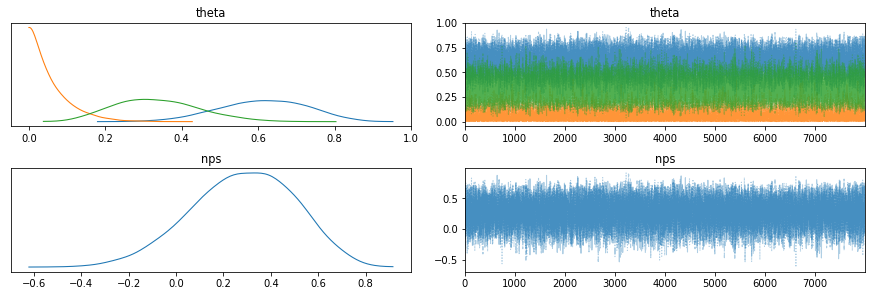

In [6]:
with conjugate_model:
    pm.traceplot(conjugate_burned_trace, combined=True)

Let's plot the posteriors for $\hat{\theta} = (\theta_{p}, \theta_{n}, \theta_{d}) = (\theta_{1}, \theta_{2}, \theta_{3})$, along with the posterior for $\text{nps}$.

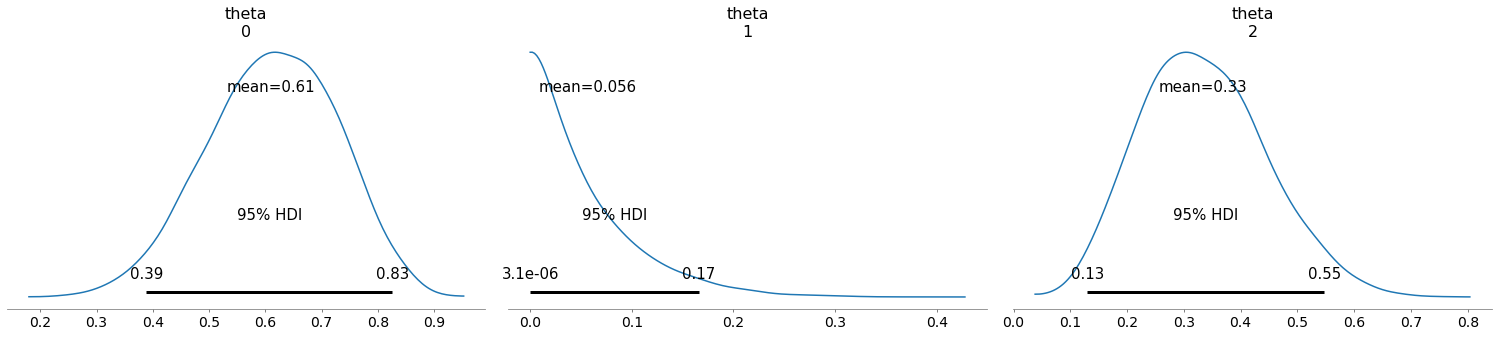

In [7]:
with conjugate_model:
    pm.plot_posterior(conjugate_burned_trace, var_names=["theta"], hdi_prob=0.95)

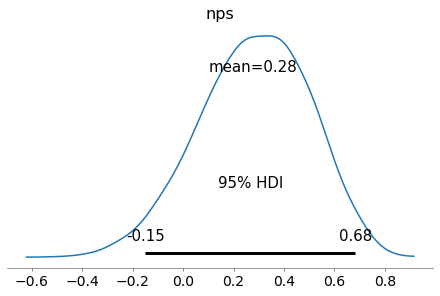

In [8]:
with conjugate_model:
    pm.plot_posterior(conjugate_burned_trace, var_names=["nps"], 
                      hdi_prob=0.95) 

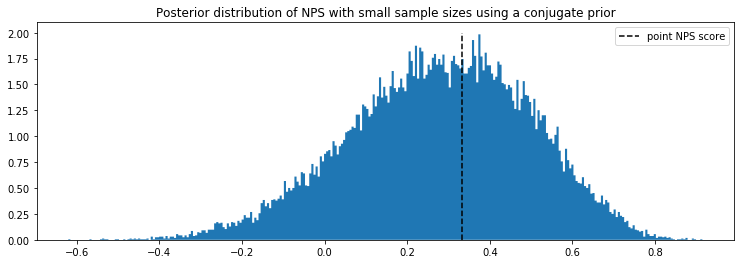

In [9]:
plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of NPS with small sample sizes using a conjugate prior")
plt.vlines(point_nps_score, 0, 2, linestyle="--", label="point NPS score")
plt.hist(conjugate_burned_trace["nps"], bins=300, histtype="stepfilled", density=True)
plt.legend();

***Note that the true distribution of the NPS score based on 
responses_counts = [10, 0, 5]  (10 promoters, 0 neutrals, 5 detractors) is pretty wide. In fact the 95% HDI or credible interval is (-0.16, 0.68) indicating anywhere bwtween a bad to a very good NPS score. Just looking at the point NPS score of 0.333 wouldn't have given us this richer picture.***

Let's now look at how the posterior distribution for NPS changes if we change the number of promoters, neutrals and detractors while keeping the point NPS score the same

#### Model 2: Larger Sample sizes

In [10]:
number_of_arms = 3 # (promoter, neutral, detractor)

responses_counts = [353, 627, 20] # (353 promoters, 627 neutrals and 20 detractors)

point_nps_score = (responses_counts[0] - responses_counts[2])/sum(responses_counts)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 15.673:   6%|▌         | 11109/200000 [00:05<01:25, 2208.42it/s]
Convergence achieved at 11200
Interrupted at 11,199 [5%]: Average Loss = 133.98
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:20<00:00, 2032.24draws/s]


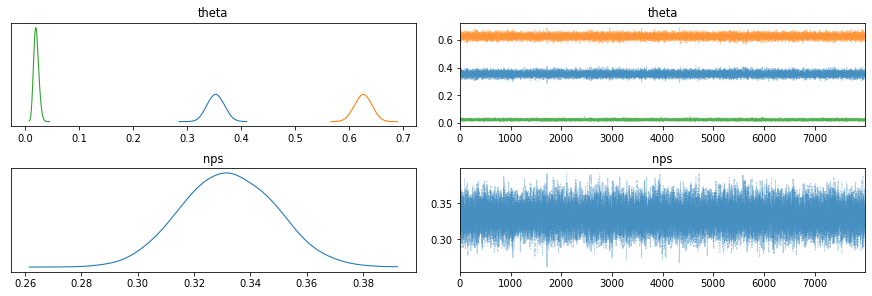

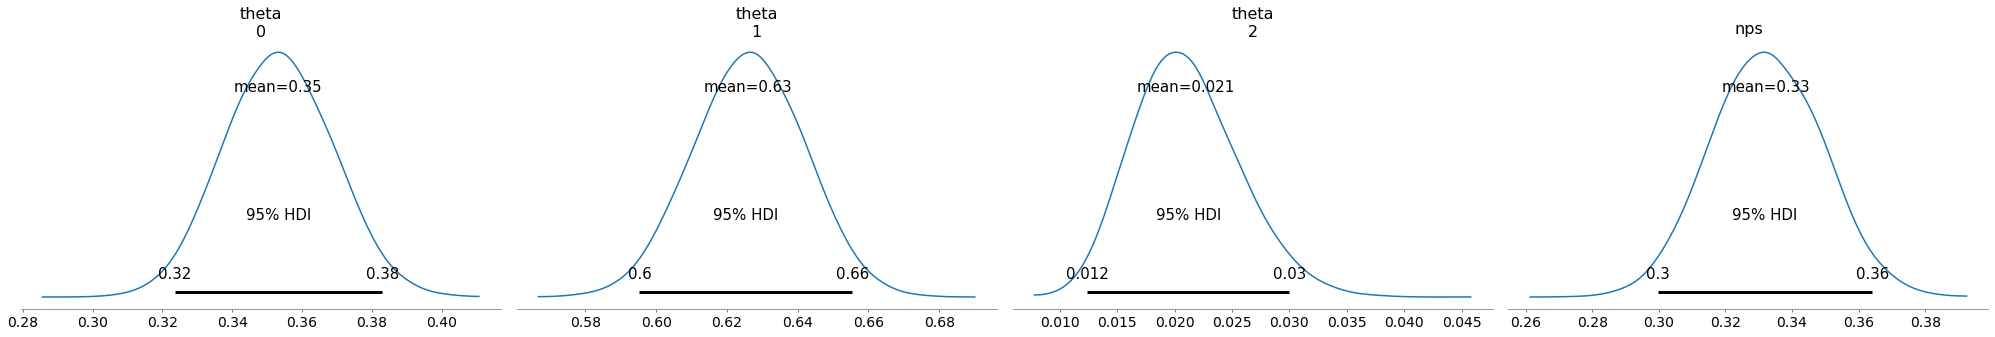

In [11]:
with pm.Model() as conjugate_model_2:
    
    theta = pm.Dirichlet('theta', a=np.ones(number_of_arms))
    observed = pm.Multinomial('observed', 
                              n=sum(responses_counts),
                              p=theta, 
                              observed=responses_counts)
    
    nps = pm.Deterministic("nps", theta[0] - theta[2]) #proportion of promoters - proportion of detractors
    
    # Inference button
    conjugate_trace_2 = pm.sample(10000, init="advi+adapt_diag") # Defaults to NUTS sampler
    conjugate_burned_trace_2 = conjugate_trace_2[2000:] # Burn the first few samples 
    
    # Trace plot
    pm.traceplot(conjugate_burned_trace_2, combined=True)
    
    # Posterior plot
    pm.plot_posterior(conjugate_burned_trace_2, 
                      hdi_prob=0.95) 

In [12]:
with conjugate_model_2:
    conjugate_model_2_posterior_df = pm.summary(conjugate_burned_trace_2)
conjugate_model_2_posterior_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],0.353,0.015,0.325,0.382,0.0,0.0,28099.0,27872.0,27839.0,20951.0,1.0
theta[1],0.626,0.016,0.597,0.655,0.0,0.0,28171.0,28171.0,28148.0,20882.0,1.0
theta[2],0.021,0.005,0.013,0.030,0.0,0.0,30681.0,29985.0,30058.0,21544.0,1.0
nps,0.332,0.017,0.301,0.362,0.0,0.0,26933.0,26880.0,26911.0,22140.0,1.0


Convergence diagnostics look okay and the sampling algorithm seems to have converged. All r_hat values
are 1.

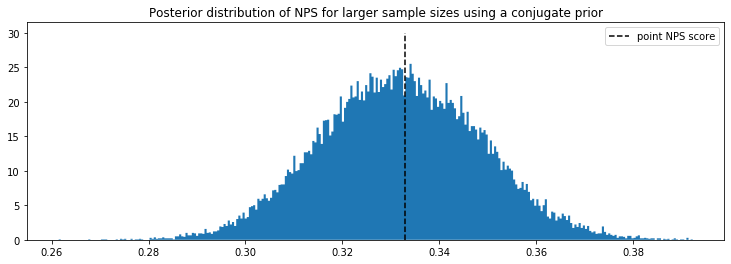

In [13]:
plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of NPS for larger sample sizes using a conjugate prior")
plt.vlines(point_nps_score, 0, 30, linestyle="--", label="point NPS score")
plt.hist(conjugate_burned_trace_2["nps"], bins=300, histtype="stepfilled", density=True)
plt.legend();

***Note that the true distribution of the NPS score based on 
responses_counts = [353, 627, 20]  (353 promoters, 627 neutrals, 20 detractors) is much narrower. In fact the 95% HDI or credible interval is (0.3, 0.36) which is a tighter band around the point NPS score of 0.333. Just looking at the point NPS score of 0.333 wouldn't have given us this richer picture. Because we many more samples we can be more confident in correctly interpreting the NPS score.***

### Model 2 - Hierarchical model; Larger sample sizes

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 16.772:   6%|▌         | 11351/200000 [00:05<01:28, 2122.53it/s]
Convergence achieved at 11500
Interrupted at 11,499 [5%]: Average Loss = 133.28
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, mu_a, sigma_a]
Sampling 4 chains, 562 divergences: 100%|██████████| 48000/48000 [00:58<00:00, 815.87draws/s] 
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


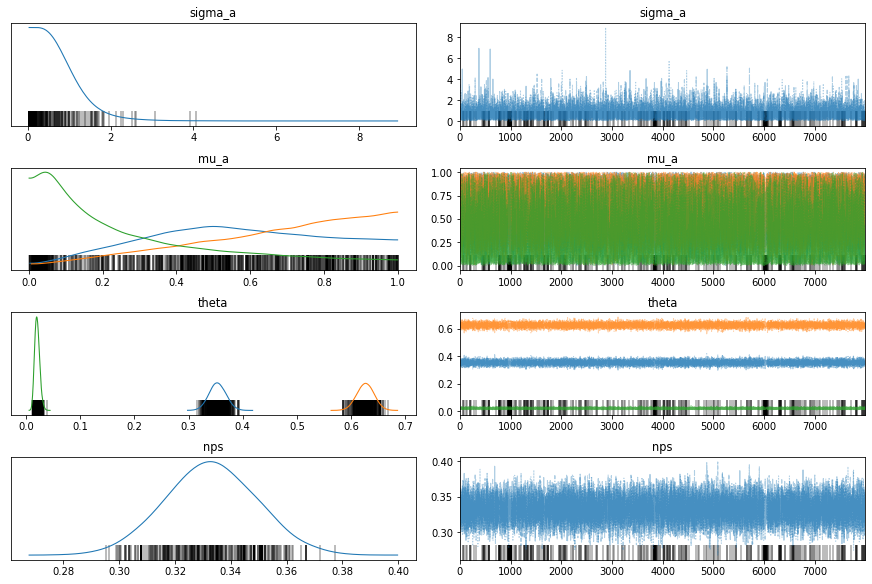

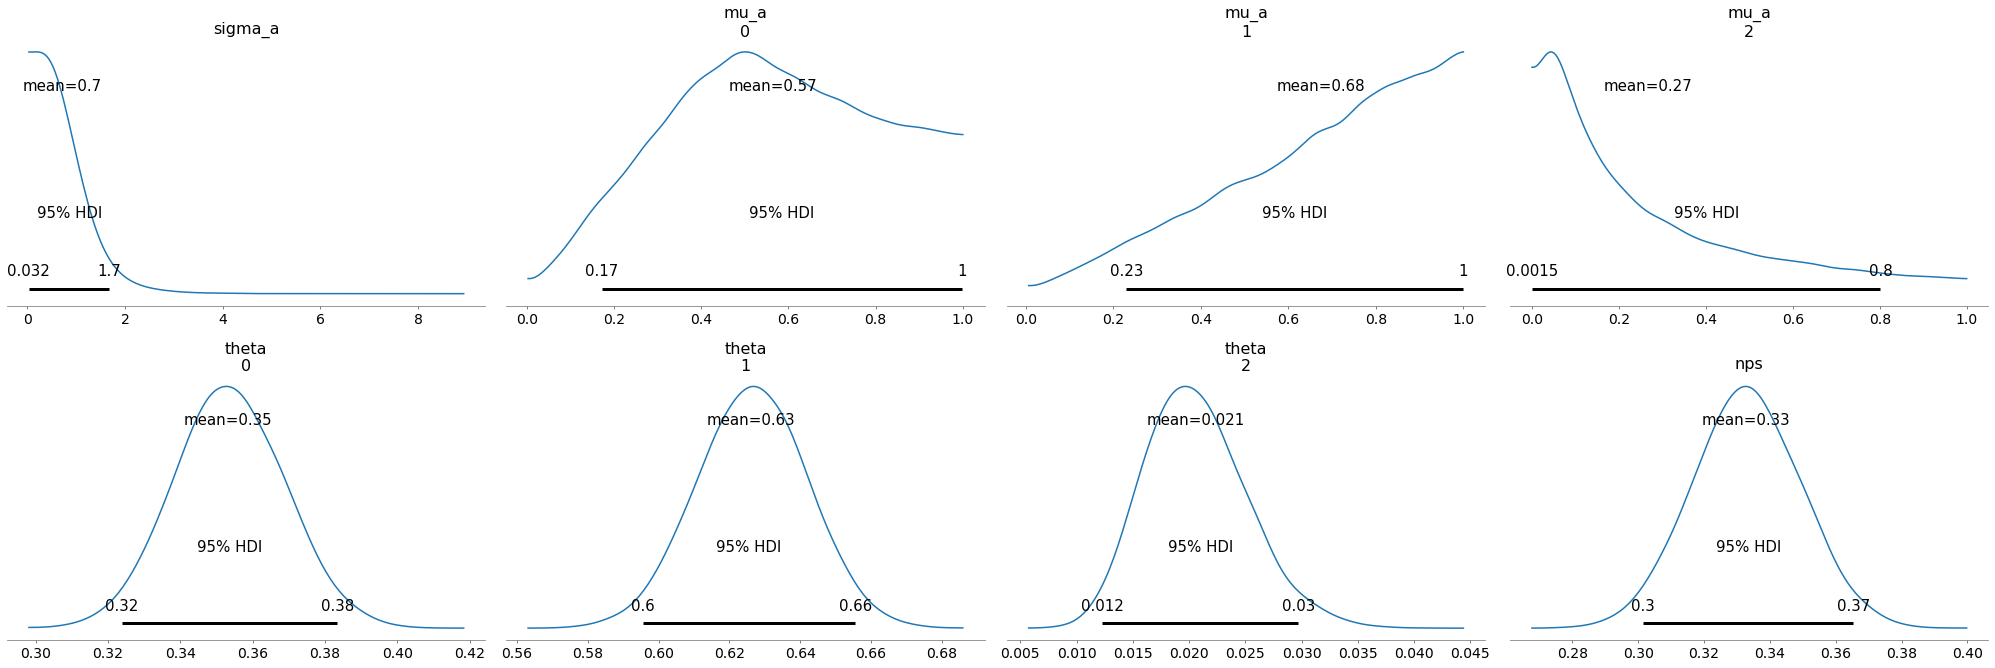

In [14]:
with pm.Model() as hierarchical_model:
    
    sigma_a = pm.HalfCauchy('sigma_a', 1) # scale parameter is 1 and 'centered' at 0
    
    mu_a = pm.Uniform('mu_a', 0, 1, shape=number_of_arms)
    
    theta = pm.Dirichlet('theta', a=mu_a/sigma_a**2, shape=number_of_arms)
    
    observed = pm.Multinomial('observed', 
                              n=sum(responses_counts),
                              p=theta, 
                              observed=responses_counts)
    
    nps = pm.Deterministic("nps", theta[0] - theta[2]) #proportion of promoters - proportion of detractors
    
    
    # Inference button
    hierarchical_trace = pm.sample(10000, tune=2000, init="advi+adapt_diag", 
                                   target_accept=0.8) # Defaults to NUTS sampler
    hierarchical_burned_trace = hierarchical_trace[2000:] # Burn the first few samples 
    
    # Trace plot
    pm.traceplot(hierarchical_burned_trace, combined=True)
    
    # Posterior plot for
    pm.plot_posterior(hierarchical_burned_trace, 
                      hdi_prob=0.95) 

In [15]:
with hierarchical_model:
    hierachical_model_posterior_df = pm.summary(hierarchical_burned_trace)
hierachical_model_posterior_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.703,0.532,0.032,1.593,0.006,0.004,9095.0,9095.0,3589.0,1502.0,1.0
mu_a[0],0.565,0.238,0.188,0.999,0.002,0.001,15550.0,13505.0,15125.0,12923.0,1.0
mu_a[1],0.675,0.233,0.251,1.000,0.002,0.001,17480.0,15407.0,14107.0,9422.0,1.0
mu_a[2],0.266,0.245,0.001,0.768,0.002,0.002,11272.0,11272.0,6595.0,4557.0,1.0
theta[0],0.353,0.015,0.325,0.382,0.000,0.000,12823.0,12823.0,12823.0,5703.0,1.0
theta[1],0.626,0.015,0.596,0.654,0.000,0.000,13670.0,13641.0,13669.0,5467.0,1.0
theta[2],0.021,0.005,0.012,0.029,0.000,0.000,17440.0,17000.0,17703.0,16253.0,1.0
nps,0.333,0.016,0.301,0.363,0.000,0.000,12414.0,12414.0,12501.0,14965.0,1.0


The low number of effective samples is usually an indication of strong autocorrelation in the chain. Most of the r_hat values are close to 1, so we can assume that the sampling converged. *Note that we get a slightly tighter 
band for nps using a hierarchical model*. 

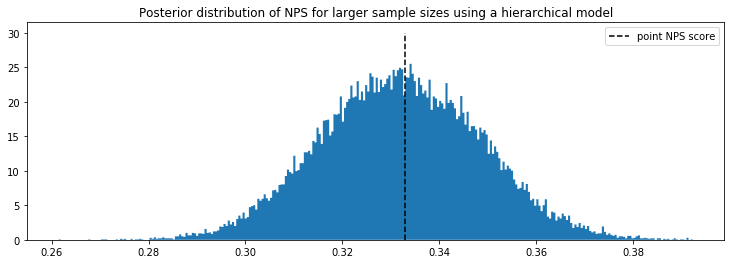

In [16]:
plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of NPS for larger sample sizes using a hierarchical model")
plt.vlines(point_nps_score, 0, 30, linestyle="--", label="point NPS score")
plt.hist(conjugate_burned_trace_2["nps"], bins=300, histtype="stepfilled", density=True)
plt.legend();

## Conclusion

1. 
Uncertainty quantification is essential for sound decision-making. For metrics like NPS, relying on a 
single number as a point estimate doesn't reveal the full picture. Because of the way NPS is defined there is no
easy way to incorporate uncertainty (like for example looking at the standard deviation like is done for binary metrics.) Using a Bayesian framework allows for a relatively straightforward way to quantify uncertainty in NPS calculations. In fact, we get a full *distribution* of values of NPS this way.

2. 
A similar analysis using a Bayesian framework can be done for different subpopulations of customers, as was done in the linked blog post.

3. 
For metrics like NPS (and in general for any metric), instead of reporting out a point estimate, report out two numbers (say for instance, the 95% credible interval). This allows for uncertainty quantification and almost always gives a more complete picture.